In [1]:
import pandas as pd
import numpy as np
import statsmodels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# BTC

In [3]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

### ADX calculation
Below 20: Indicates a weak trend or a ranging market. The asset is likely moving sideways, and trading strategies that depend on trend-following may be less effective. <br>
20 to 25: Indicates a potential emerging trend. Traders may begin to look for signals to enter positions. <br>
25 to 40: Indicates a strengthening trend. This is often where trend-following strategies can be more effective. Depending on the asset, this could be considered a moderately strong trend. <br>
40 to 60: Indicates a strong trend. Here, the asset is trending strongly in one direction, making it more suitable for trend-following strategies. <br>
Above 60: Indicates an extremely strong trend, which might also signal an overbought or oversold condition, suggesting potential reversals. <br>

In [4]:
# Calculate lagged prices
btc['PrevHigh'] = btc['High'].shift(1)
btc['PrevLow'] = btc['Low'].shift(1)
btc['PrevClose'] = btc['Close'].shift(1)

# Calculate true range component
btc['TR1'] = btc['High'] - btc['Low']
btc['TR2'] = abs(btc['High'] - btc['PrevClose'])
btc['TR3'] = abs(btc['Low'] - btc['PrevClose'])

# Calculate true range as the max of the three TRs
btc['TR'] = btc[['TR1', 'TR2', 'TR3']].max(axis=1)
btc.at[btc.index[0], 'TR'] = np.nan

In [5]:
# Initialize +DM and -DM columns
btc['+DM'] = 0.0
btc['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(btc)):
    high_diff = btc['High'].iloc[i] - btc['PrevHigh'].iloc[i]
    low_diff = btc['PrevLow'].iloc[i] - btc['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        btc.at[btc.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        btc.at[btc.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
btc['TR_smooth'] = btc['TR'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

btc['+DM_smooth'] = btc['+DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '+DM_smooth'] = np.nan
btc['-DM_smooth'] = btc['-DM'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
btc['+DI'] = (btc['+DM_smooth'] / btc['TR_smooth']) * 100
btc['-DI'] = (btc['-DM_smooth'] / btc['TR_smooth']) * 100

# Calculate DX and ADX
btc['DX'] = (abs(btc['+DI'] - btc['-DI']) / (btc['+DI'] + btc['-DI'])) * 100
btc['ADX'] = btc['DX'].ewm(span=period, adjust=False).mean()
btc.loc[btc.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [6]:
# Calculate price changes
btc['PriceChange'] = btc['Close'].diff()

# Separate gains and losses
btc['Gain'] = btc['PriceChange'].where(btc['PriceChange'] > 0, 0)
btc['Loss'] = -btc['PriceChange'].where(btc['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
btc['AvgGain'] = btc['Gain'].rolling(window=window, min_periods=1).mean()
btc['AvgLoss'] = btc['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
btc['RS'] = btc['AvgGain'] / btc['AvgLoss']

# Calculate RSI
btc['RSI'] = 100 - (100 / (1 + btc['RS']))

btc.loc[btc.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator
Varies from value of 0 to 100, the bounds of 80 and 20 are frequently taken as overbought and oversold levels

In [7]:
k_period = 12
d_period = 3
btc['HighestHigh'] = btc['High'].rolling(window=k_period).max()
btc['LowestLow'] = btc['Low'].rolling(window=k_period).min()

# Calculate %K
btc['%K'] = 100 * (btc['Close'] - btc['LowestLow']) / (btc['HighestHigh'] - btc['LowestLow'])

# Calculate %D (the moving average of %K)
btc['%D'] = btc['%K'].rolling(window=d_period).mean()

### MACD

In [8]:
btc['EMA_6'] = btc['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
btc['MACD'] = btc['EMA_6'] - btc['EMA_12']

### Breaking of 2 consecutive high

In [9]:
btc['PrevHigh2'] = btc['High'].shift(2)
btc['BreakHigh2'] = (btc['High'] > btc['PrevHigh']) & (btc['PrevHigh'] > btc['PrevHigh2'])

In [10]:
btc['TROpen'] = btc['Open'].diff()
btc['TRHigh'] = btc['High'].diff()
btc['TRLow'] = btc['Low'].diff()
btc['TRClose'] = btc['Close'].diff()
btc['TRShort_SMA'] = btc['SMAVG (5)  on Close'].diff()
btc['TRLong_SMA'] = btc['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
btc['Short_EMA'] = btc['Close'].ewm(span=5, adjust=False).mean()
btc['Long_EMA'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['TRShort_EMA'] = btc['Short_EMA'].diff()
btc['TRLong_EMA'] = btc['Long_EMA'].diff()

btc['DayOfWeek'] = btc['Date'].dt.dayofweek

### Final BTC data (stationary)

In [11]:
btc = btc.drop(columns=['Open', 'High', 'Low', 'Close', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
btc.drop(index=btc.index[:20], inplace=True)
btc

,Date,ADX,RSI,%K,%D,MACD,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek
20,2024-01-01 10:00:00,34.638980,46.213708,68.685093,71.478756,11.198485,False,115.85,-120.74,37.03,-64.03,51.21,-7.52,17.240130,12.363108,0
21,2024-01-01 10:30:00,35.421038,53.400626,74.354119,73.782507,20.190863,False,-64.03,-25.50,-21.64,37.72,32.20,6.33,24.066754,16.973452,0
22,2024-01-01 11:00:00,31.442584,44.126566,52.829253,65.289488,5.852152,False,37.72,-15.98,-72.83,-143.22,-6.96,-12.13,-31.695498,-12.152630,0
23,2024-01-01 11:30:00,30.377071,53.763073,37.769963,54.984445,-16.284526,False,-143.22,-129.37,-171.35,-100.20,-30.78,6.38,-54.530332,-28.161243,0
24,2024-01-01 12:00:00,30.768291,57.753855,33.904444,41.501220,-32.339681,False,-100.20,-77.53,-41.89,-25.72,-59.09,12.23,-44.926888,-27.717381,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20950,2025-03-12 14:30:00,43.747651,8.776190,5.883332,10.480370,-260.187689,False,-282.64,-209.00,-212.06,-256.28,-88.52,-187.74,-152.305616,-122.716529,2
20951,2025-03-12 15:00:00,44.822514,23.382916,16.022949,10.102204,-234.764535,False,-258.95,72.44,26.21,249.90,-18.37,-102.39,-18.237077,-54.968069,2
20952,2025-03-12 15:30:00,40.067170,49.593626,55.367956,25.758079,-113.087485,True,249.90,661.42,261.35,727.94,124.12,-1.93,230.488615,87.378853,2
20953,2025-03-12 16:00:00,39.182225,52.925797,79.819005,50.403303,-23.300806,True,727.94,302.40,454.42,85.50,104.35,13.96,182.159077,87.037243,2


### ADF Test

In [16]:
from statsmodels.tsa.stattools import adfuller
btc.dropna(inplace=True)
result = adfuller(btc['TRLong_EMA'])
result

(np.float64(-22.552144714255295),
 0.0,
 43,
 20891,
 {'1%': np.float64(-3.4306630584311857),
  '5%': np.float64(-2.861678361148952),
  '10%': np.float64(-2.5668436458024897)},
 np.float64(226595.63651538393))

# SPY

In [12]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

In [13]:
# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

### ADX

In [18]:
# Calculate lagged prices
spy['PrevHigh'] = spy['High'].shift(1)
spy['PrevLow'] = spy['Low'].shift(1)
spy['PrevClose'] = spy['Close'].shift(1)

# Calculate true range component
spy['TR1'] = spy['High'] - spy['Low']
spy['TR2'] = abs(spy['High'] - spy['PrevClose'])
spy['TR3'] = abs(spy['Low'] - spy['PrevClose'])

# Calculate true range as the max of the three TRs
spy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)
spy.at[spy.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
spy['+DM'] = 0.0
spy['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(spy)):
    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]
    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        spy.at[spy.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        spy.at[spy.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
spy['TR_smooth'] = spy['TR'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

spy['+DM_smooth'] = spy['+DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '+DM_smooth'] = np.nan
spy['-DM_smooth'] = spy['-DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
spy['+DI'] = (spy['+DM_smooth'] / spy['TR_smooth']) * 100
spy['-DI'] = (spy['-DM_smooth'] / spy['TR_smooth']) * 100

# Calculate DX and ADX
spy['DX'] = (abs(spy['+DI'] - spy['-DI']) / (spy['+DI'] + spy['-DI'])) * 100
spy['ADX'] = spy['DX'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs

### RSI

In [14]:
# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Separate gains and losses
spy['Gain'] = spy['PriceChange'].where(spy['PriceChange'] > 0, 0)
spy['Loss'] = -spy['PriceChange'].where(spy['PriceChange'] < 0, 0)

# Calculate average gains and losses (using a 10-period window)
window = 10
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

spy.loc[spy.index[:12], 'RSI'] = np.nan # first few ADXs are not stable due to NAs

### Stochastic Oscillator

In [15]:
k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()

### MACD

In [16]:
spy['EMA_6'] = spy['Close'].ewm(span=6, adjust=False).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].ewm(span=12, adjust=False).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

### Breaking of 2 consecutive highs

In [19]:
spy['PrevHigh2'] = spy['High'].shift(2)
spy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])

In [20]:
spy['TROpen'] = spy['Open'].diff()
spy['TRHigh'] = spy['High'].diff()
spy['TRLow'] = spy['Low'].diff()
spy['TRClose'] = spy['Close'].diff()
spy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()
spy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
spy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['TRShort_EMA'] = spy['Short_EMA'].diff()
spy['TRLong_EMA'] = spy['Long_EMA'].diff()

spy['DayOfWeek'] = spy['Date'].dt.dayofweek

### Final SPY data (stationary)

In [21]:
spy = spy.drop(columns=['Open', 'High', 'Low', 'Close', 'PrevHigh', 'PrevLow', 'PrevClose', 'SMAVG (5)  on Close', 'Volume', 'SMAVG (5)', 'SMAVG (10)  on Close', 'SMAVG (15)  on Close', 'TR1', 'TR2', 'TR3', 'TR', '+DM', '-DM', 'TR_smooth', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX', 'PriceChange', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS', 'HighestHigh', 'LowestLow', 'PrevHigh2', 'EMA_6', 'EMA_12', 'Short_EMA', 'Long_EMA'])

# Drop first 20 rows due to NAs
spy.drop(index=spy.index[:20], inplace=True)
spy

,Date,RSI,%K,%D,MACD,ADX,BreakHigh2,TROpen,TRHigh,TRLow,TRClose,TRShort_SMA,TRLong_SMA,TRShort_EMA,TRLong_EMA,DayOfWeek
20,2024-01-04 02:00:00,45.760234,41.414141,33.122214,-0.333418,18.975209,True,0.770,0.380,0.842,0.035,0.190,-0.059,0.144235,0.013987,3
21,2024-01-04 02:30:00,44.209040,34.595960,37.924936,-0.281867,16.859306,False,0.015,-0.340,-0.403,-0.270,0.074,-0.082,0.006156,-0.037647,3
22,2024-01-04 03:00:00,36.951317,58.207071,44.739057,-0.115023,18.382683,False,-0.265,0.760,-0.910,0.935,0.347,-0.163,0.315771,0.139198,3
23,2024-01-04 03:30:00,54.870822,38.156566,43.653199,-0.113831,19.629082,False,0.940,-0.010,1.230,-0.794,0.130,0.041,-0.054153,-0.030475,3
24,2024-01-04 04:00:00,47.731959,22.580645,39.648094,-0.233513,25.761205,False,-0.790,-0.890,-1.210,-0.951,-0.209,-0.022,-0.353102,-0.197843,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3863,2025-03-12 01:30:00,33.055638,20.909091,9.505525,-1.887391,49.119195,False,-2.180,1.035,-0.020,2.145,-0.597,-0.569,-0.146827,-0.407416,2
3864,2025-03-12 02:00:00,44.663060,61.435407,27.512084,-1.116302,42.809022,True,2.180,3.930,2.130,4.235,0.268,-0.217,1.313782,0.436660,2
3865,2025-03-12 02:30:00,55.407883,86.912442,56.418980,-0.204267,42.239925,True,4.160,3.550,3.190,3.010,1.080,0.236,1.879188,0.904540,2
3866,2025-03-12 03:00:00,59.076472,63.558333,70.635394,0.118183,42.922041,True,2.980,1.150,1.270,-1.803,1.083,0.371,0.651792,0.412260,2


In [40]:
#test for stationarity (ADF)
spy.dropna(inplace=True)
result = adfuller(spy['TRLong_EMA'])
result

(np.float64(-20.107634439059215),
 0.0,
 0,
 3847,
 {'1%': np.float64(-3.4320509796639875),
  '5%': np.float64(-2.862291599506988),
  '10%': np.float64(-2.5671700858277515)},
 np.float64(-243.5542666651172))

# TLT

In [ ]:
tlt = pd.read_excel('../data/pricing_data.xlsx', sheet_name='TLT - iShares 20+ Year Bond')
tlt

,Date,Open,High,Low,Close,SMAVG (5) on Close,SMAVG (10) on Close,SMAVG (15) on Close,Volume,SMAVG (5)
0,2025-03-12 03:30:00,90.43,90.45,90.31,90.4,90.457,90.548,90.744,7288227,3185873
1,2025-03-12 03:00:00,90.28,90.44,90.26,90.435,90.553,90.622,90.801,1907296,2632538
2,2025-03-12 02:30:00,90.37,90.43,90.14,90.28,90.597,90.714,90.848,2182891,2544396
3,2025-03-12 02:00:00,90.8,90.8,90.24,90.37,90.66,90.779,90.913,2897936,2394195
4,2025-03-12 01:30:00,90.89,90.99,90.65,90.8,90.69,90.851,90.97,1653012,2325624
...,...,...,...,...,...,...,...,...,...,...
3871,2024-01-03 00:30:00,98.389,98.53,98.29,98.36,98.368,98.712,98.932,1969505,3779156
3872,2024-01-03 00:00:00,98.195,98.5,98.08,98.385,98.472,98.765,99.014,3502224,5024401
3873,2024-01-02 23:30:00,98.3,98.505,98,98.196,98.612,98.854,99.08,4374639,4499693
3874,2024-01-02 23:00:00,98.598,98.61,98.13,98.305,98.794,98.992,99.152,3502950,3785197


### Autocorrelation plot to determine the optimal number of lags for BTC and SPY

In [22]:
btc['Date'] = pd.to_datetime(btc['Date'])  # Convert to datetime
btc.set_index('Date', inplace=True)  # Set Date as index

spy['Date'] = pd.to_datetime(spy['Date'])  # Convert to datetime
spy.set_index('Date', inplace=True)  # Set Date as index

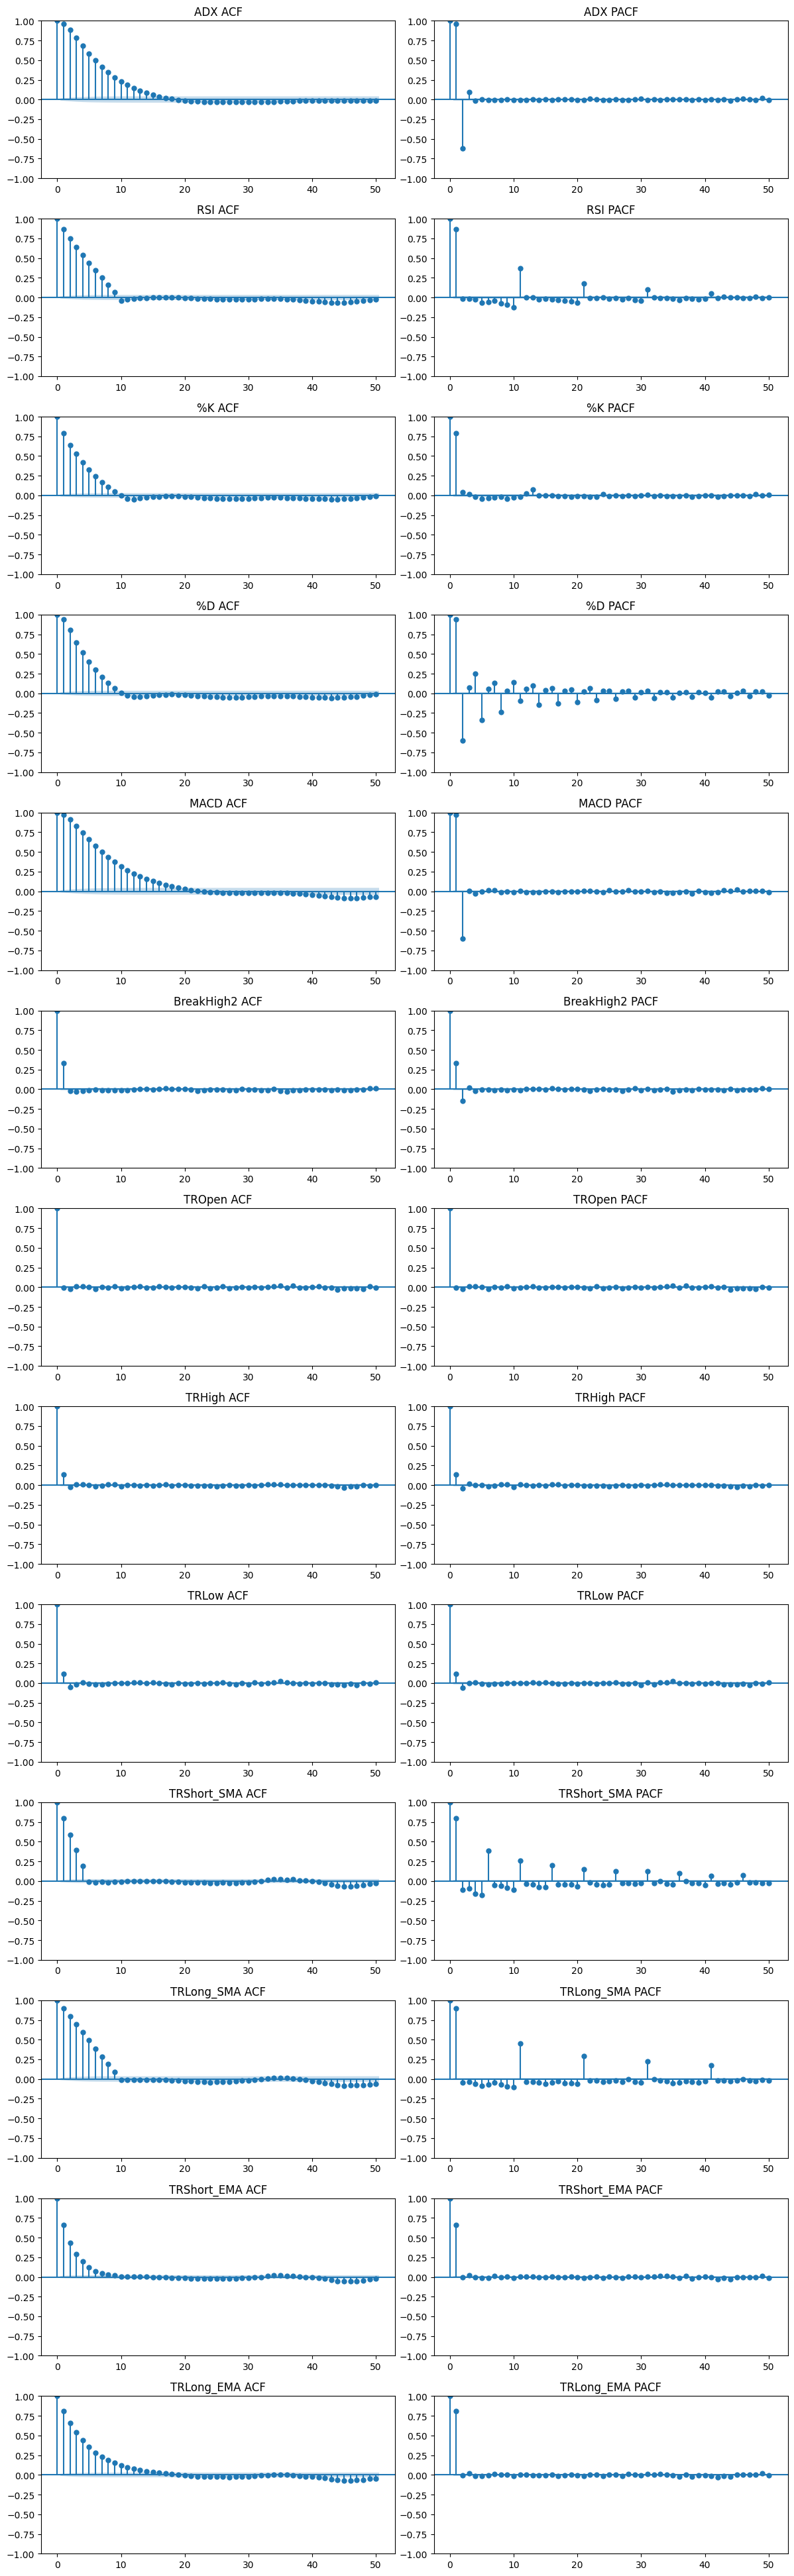

In [23]:
#plot the PACF for BTC
indicators = ['ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA']

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(btc[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(btc[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()

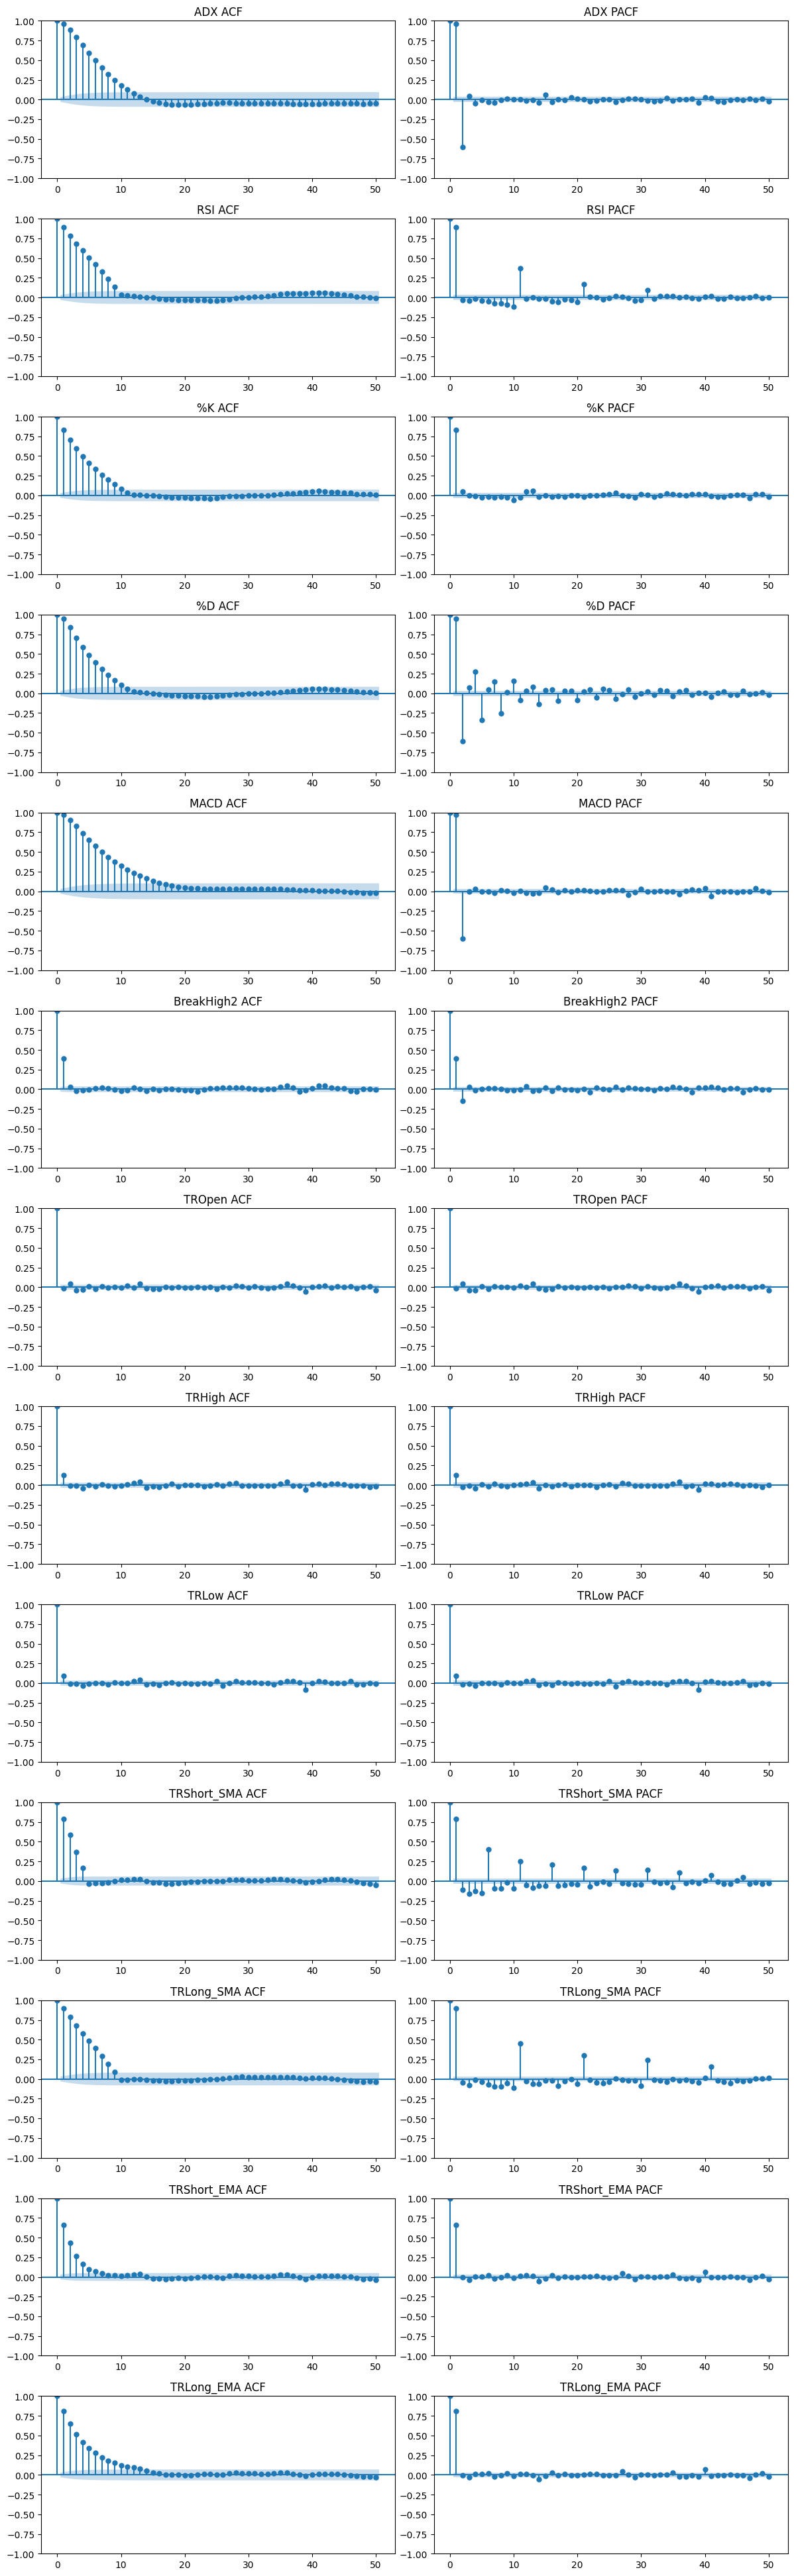

In [24]:
#plot the PACF for SPY
indicators = ['ADX', 'RSI', '%K', '%D', 'MACD', 'BreakHigh2',
              'TROpen', 'TRHigh', 'TRLow', 'TRShort_SMA', 'TRLong_SMA', 'TRShort_EMA', 'TRLong_EMA']

fig, axes = plt.subplots(len(indicators), 2, figsize=(12, 3 * len(indicators)))

for i, indicator in enumerate(indicators):
    plot_acf(spy[indicator].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'{indicator} ACF')

    plot_pacf(spy[indicator].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'{indicator} PACF')

plt.tight_layout()
plt.show()